# 06 Backscatter Variability

In this notebook we want to look at how different surfaces like water, forest grasland and cities give us different backscatter.

We are going to load backscatering data from Sentinel 1 and we will use the Corine Landcoverdata to get a classification of different surfaces.

## Import packages

In [2]:
import os
import xarray as xr
import rioxarray
import rasterio
from rasterio.crs import CRS
import dask.array as da
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import folium
import matplotlib.patches as patches
from datetime import datetime
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

## Load Sentinel 1 data

Load Metadata to get some information on the data. Using '.tags()' we can extract a lot of useful information like the scale_factor.

In [3]:
data_path = Path('~/shared/datasets/rs/datapool/mrs/saocom_gamma/S1gammaNeusiedler').expanduser() # SAT-1 data is inside the saocom_gamma folder but this could change
tif_files = glob(f"{data_path}/*.tif")

for tif_path in tif_files:
    print(f"Metadata for file: {os.path.basename(tif_path)}")
    with rasterio.open(tif_path) as src:
      tags = src.tags()
      print(src.meta)
      print(f"Tags: {tags}")
      print(f"Scalefactor: {tags.get('scale_factor')}\n")
      break
    

Metadata for file: D20230829_165123--_GMR------_S1AIWGRDH1VVA_146_A0105_EU010M_E052N015T1.tif
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 10000, 'height': 10000, 'count': 1, 'crs': CRS.from_epsg(27704), 'transform': Affine(10.0, 0.0, 5200000.0,
       0.0, -10.0, 1600000.0)}
Tags: {'abs_orbit_number': '050093', 'band_1': 'Gamma0_VV', 'border_noise_removed': 'True', 'creator': 'TUWGEO', 'distanceuom': 'm', 'distancevalue': '10', 'equi7_tile': 'EU010M_E052N015T1', 'ext_dem': '/eodc/private/tuwgeo/users/acube/data/input/acube_dem_eh.tif', 'grid': 'Equi7 Grid', 'gtc_applied': 'True', 'log_file': 'tasklist_2_A01_gmr_jobfile_A0105_log_20231201_073256.xml', 'orbit_aux_file': 'POE', 'parent_data_file': 'S1A_IW_GRDH_1SDV_20230829T165123_20230829T165148_050093_060726_855E.zip', 'polarisation': 'VV', 'precise_orbit_applied': 'True', 'processing_date': '2023-12-01 07:32:57', 'processing_software': 'SGRT', 'processing_software_version': 'A0105-2.4.9.post.dev6.pre', 'rel_orbit_

As we can see frome here the data was captured 8 images between the 5th August 2023 and the 28th October 2023. The image contains Gamma VV values.

Now we can load the data and and apply preprocessing. From the Metaddata we could extract a scalingfactor of 100 which we now need to apply.

We get a xarray.DataSet and convert it to an xarray.DataArray because we only have one variable, the VV backscatter.

We have 8 timestemps. For performance reasons we will fous on only on one time becasue the data does not change to much over time.

We downsample already in the preprocessing because we do not need all the resolution because we are working with the corine data map and the resolution there is 100 by 100 meters. When we downsample x and y coordinates by 10 we get pixles of size 100 by 100meters which fits perfectly to the 

(insert image of downscaled, normal and corine landcover)

In [5]:
def _preprocess(x):  
    scale_factor = pd.to_numeric(
        rasterio.open(x.encoding["source"]).tags().get('scale_factor')
    )

    time_value = pd.to_datetime(
        rasterio.open(x.encoding["source"]).tags().get('time_begin')
    )

    x = x / scale_factor

    x = x.assign_coords(time=time_value).expand_dims("time")

    #x_downscaled = x.coarsen(x=10, y=10, boundary='pad').mean()
    #return x_downscaled.squeeze("band").drop_vars("band")
    
    return x.squeeze("band").drop_vars("band")

ds = xr.open_mfdataset(
    '~/shared/datasets/rs/datapool/mrs/saocom_gamma/S1gammaNeusiedler/*.tif',
    engine="rasterio",
    combine='nested',
    concat_dim="time",
    preprocess=_preprocess
)

ds = ds[list(ds.data_vars.keys())[0]] .isel(time=0).compute()
#ds = ds[list(ds.data_vars.keys())[0]].mean(dim='time').compute()

ds

<xarray.DataArray 'band_data' (y: 10000, x: 10000)> Size: 400MB
array([[-4.74, -7.08, -6.7 , ...,   nan,   nan,   nan],
       [-4.66, -4.26, -4.36, ...,   nan,   nan,   nan],
       [-6.34, -4.9 , -4.95, ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]], dtype=float32)
Coordinates:
  * x            (x) float64 80kB 5.2e+06 5.2e+06 5.2e+06 ... 5.3e+06 5.3e+06
  * y            (y) float64 80kB 1.6e+06 1.6e+06 1.6e+06 ... 1.5e+06 1.5e+06
    spatial_ref  int64 8B 0
    time         datetime64[ns] 8B 2023-08-05T16:51:22

To get an idea of the region we are looking at we want to display it. Using 'rubust=True' will use the 2nd and 98th percentiles of the data to compute the color limits. 

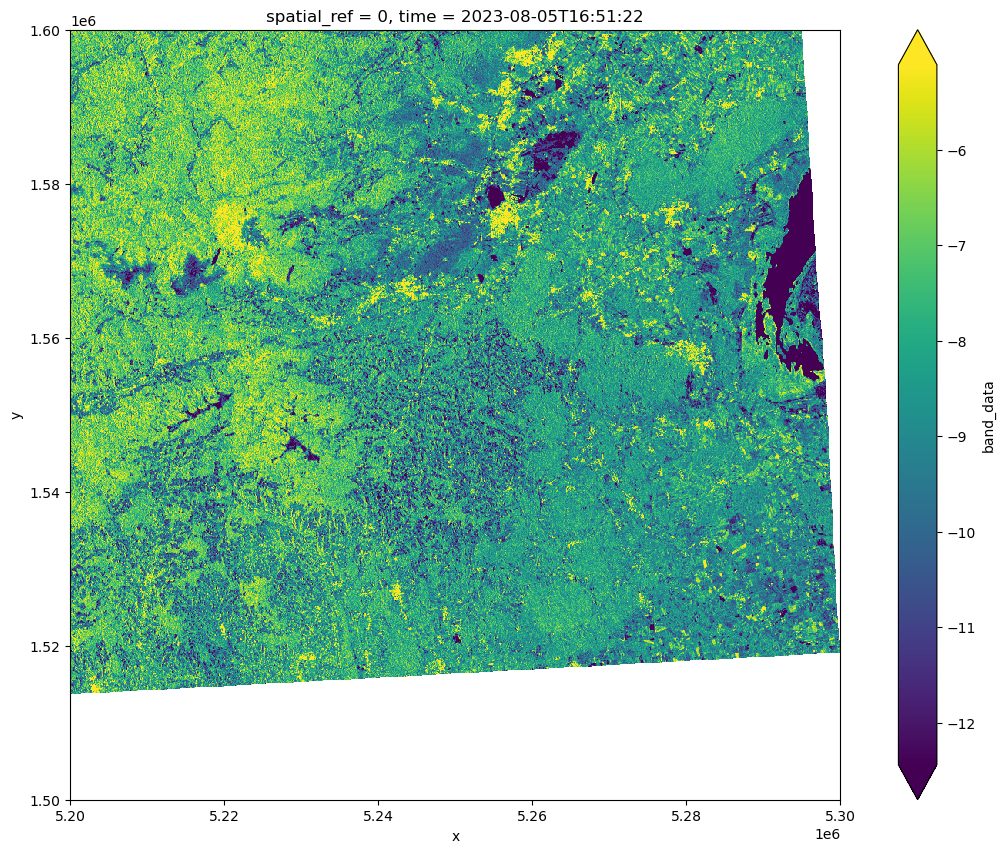

In [16]:
ds_downscaled = ds.coarsen(x=10, y=10, boundary='pad').mean().compute()
ds_downscaled.plot(figsize=(15, 10), robust=True).axes.set_aspect('equal')

plt.show()

### Convert to the Corine Landcover coordinates

In [6]:
ds_3035 = ds.rio.reproject("EPSG:3035")
ds_3035

<xarray.DataArray 'band_data' (y: 11746, x: 11692)> Size: 549MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 94kB 4.728e+06 4.728e+06 ... 4.845e+06 4.845e+06
  * y            (y) float64 94kB 2.797e+06 2.797e+06 ... 2.68e+06 2.68e+06
    time         datetime64[ns] 8B ...
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  nan

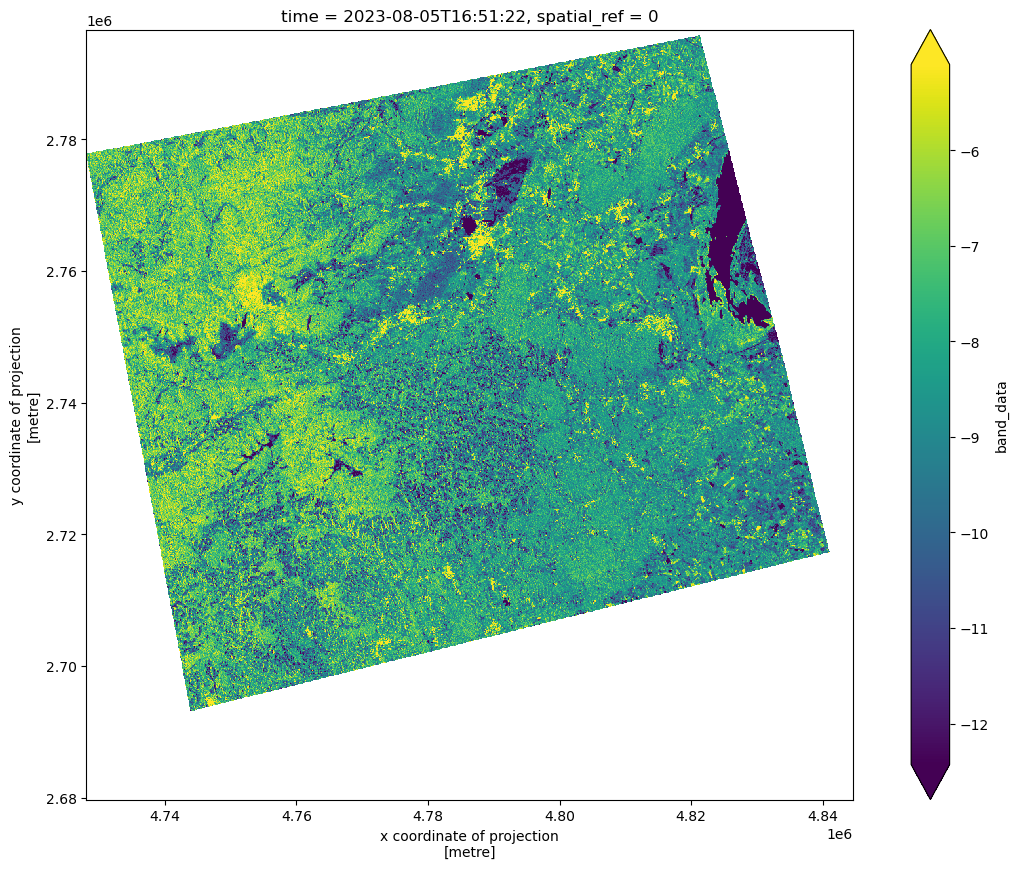

In [17]:
ds_3035_downscaled = ds_3035.coarsen(x=10, y=10, boundary='pad').mean().compute()
ds_3035_downscaled.plot(figsize=(15, 10), robust=True).axes.set_aspect('equal')

plt.show()

In [7]:
bbox_3035 = ds_3035.rio.transform_bounds(ds_3035.rio.crs)
bbox_3035

(4728101.713910273, 2679704.353635614, 4844559.993472351, 2796700.5007221834)

In [8]:
ds_backscatter = ds_3035

Here we get a rectangular box that has the Sentinel-1 data in it. With this box we can only load the part of the corine data that we want.

## Load Corine Landcover data

We load the Corine Land Cover data which classifies the landcover of europa in 44 different areas.

In [9]:
tif_path = Path('~/shared/datasets/rs/datapool/mrs/Corine_Land_Cover_2018.tif').expanduser()

with rasterio.open(tif_path) as src:
    meta = src.meta
    tags = src.tags()
    crs = src.crs

print(f"Metadata for file: {tif_path.name}")
print("Metadata:")
print(meta)
print("\nTags:")
print(tags)

Metadata for file: Corine_Land_Cover_2018.tif
Metadata:
{'driver': 'GTiff', 'dtype': 'int8', 'nodata': -128.0, 'width': 65000, 'height': 46000, 'count': 1, 'crs': CRS.from_wkt('PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]'), 'transform': Affine(100.0, 0.0, 900000.0,
       0.0, -100.0, 5500000.0)}

Tags:
{'DataType': 'Thematic', 'AREA_OR_POINT': 'Area'}


### Colormapping and Encoding

In [10]:
# mapping from https://collections.sentinel-hub.com/corine-land-cover/readme.html

color_mapping = {
    1: ("#e6004d", "Continuous urban fabric"),
    2: ("#ff0000", "Discontinuous urban fabric"),
    3: ("#cc4df2", "Industrial or commercial units"),
    4: ("#cc0000", "Road and rail networks and associated land"),
    5: ("#e6cccc", "Port areas"),
    6: ("#e6cce6", "Airports"),
    7: ("#a600cc", "Mineral extraction sites"),
    8: ("#a64d00", "Dump sites"),
    9: ("#ff4dff", "Construction sites"),
    10: ("#ffa6ff", "Green urban areas"),
    11: ("#ffe6ff", "Sport and leisure facilities"),
    12: ("#ffffa8", "Non-irrigated arable land"),
    13: ("#ffff00", "Permanently irrigated land"),
    14: ("#e6e600", "Rice fields"),
    15: ("#e68000", "Vineyards"),
    16: ("#f2a64d", "Fruit trees and berry plantations"),
    17: ("#e6a600", "Olive groves"),
    18: ("#e6e64d", "Pastures"),
    19: ("#ffe6a6", "Annual crops associated with permanent crops"),
    20: ("#ffe64d", "Complex cultivation patterns"),
    21: ("#e6cc4d", "Land principally occupied by agriculture with significant areas of natural vegetation"),
    22: ("#f2cca6", "Agro-forestry areas"),
    23: ("#80ff00", "Broad-leaved forest"),
    24: ("#00a600", "Coniferous forest"),
    25: ("#4dff00", "Mixed forest"),
    26: ("#ccf24d", "Natural grasslands"),
    27: ("#a6ff80", "Moors and heathland"),
    28: ("#a6e64d", "Sclerophyllous vegetation"),
    29: ("#a6f200", "Transitional woodland-shrub"),
    30: ("#e6e6e6", "Beaches - dunes - sands"),
    31: ("#cccccc", "Bare rocks"),
    32: ("#ccffcc", "Sparsely vegetated areas"),
    33: ("#000000", "Burnt areas"),
    34: ("#a6e6cc", "Glaciers and perpetual snow"),
    35: ("#a6a6ff", "Inland marshes"),
    36: ("#4d4dff", "Peat bogs"),
    37: ("#ccccff", "Salt marshes"),
    38: ("#e6e6ff", "Salines"),
    39: ("#a6a6e6", "Intertidal flats"),
    40: ("#00ccf2", "Water courses"),
    41: ("#80f2e6", "Water bodies"),
    42: ("#00ffa6", "Coastal lagoons"),
    43: ("#a6ffe6", "Estuaries"),
    44: ("#e6f2ff", "Sea and ocean"),
    48: ("#ffffff", "NODATA")
}

colors = [color for color, label in color_mapping.values()]
categories = [key for key in color_mapping.keys()]

handles = [
    mpatches.Patch(color=color, label=f'{key} - {label}') 
    for key, (color, label) in color_mapping.items()
]

cmap = ListedColormap(colors)
norm = BoundaryNorm(categories + [max(categories) + 1], len(categories))

### Load data
maybe load and clip together?

In [11]:
ds_corine = xr.open_mfdataset(
    '~/shared/datasets/rs/datapool/mrs/Corine_Land_Cover_2018.tif',
    engine="rasterio",
    combine='nested',
    concat_dim="time"
)

ds_corine = ds_corine.squeeze()
ds_corine

<xarray.Dataset> Size: 12GB
Dimensions:      (y: 46000, x: 65000)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 520kB 9e+05 9.002e+05 9.002e+05 ... 7.4e+06 7.4e+06
  * y            (y) float64 368kB 5.5e+06 5.5e+06 5.5e+06 ... 9.002e+05 9e+05
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 12GB dask.array<chunksize=(128, 128), meta=np.ndarray>

In [12]:
from shapely.geometry import box

clip_bbox_3035 = box(bbox_3035[0], bbox_3035[1], bbox_3035[2], bbox_3035[3])
coords = list(clip_bbox_3035.exterior.coords)
coords

[(4844559.993472351, 2679704.353635614),
 (4844559.993472351, 2796700.5007221834),
 (4728101.713910273, 2796700.5007221834),
 (4728101.713910273, 2679704.353635614),
 (4844559.993472351, 2679704.353635614)]

In [13]:
ds_corine = ds_corine.rio.clip([clip_bbox_3035], crs=ds_corine.rio.crs, drop=True).squeeze()
ds_corine

<xarray.Dataset> Size: 5MB
Dimensions:      (x: 1165, y: 1170)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 9kB 4.728e+06 4.728e+06 ... 4.844e+06 4.845e+06
  * y            (y) float64 9kB 2.797e+06 2.797e+06 ... 2.68e+06 2.68e+06
    spatial_ref  int64 8B 0
Data variables:
    band_data    (y, x) float32 5MB dask.array<chunksize=(103, 119), meta=np.ndarray>

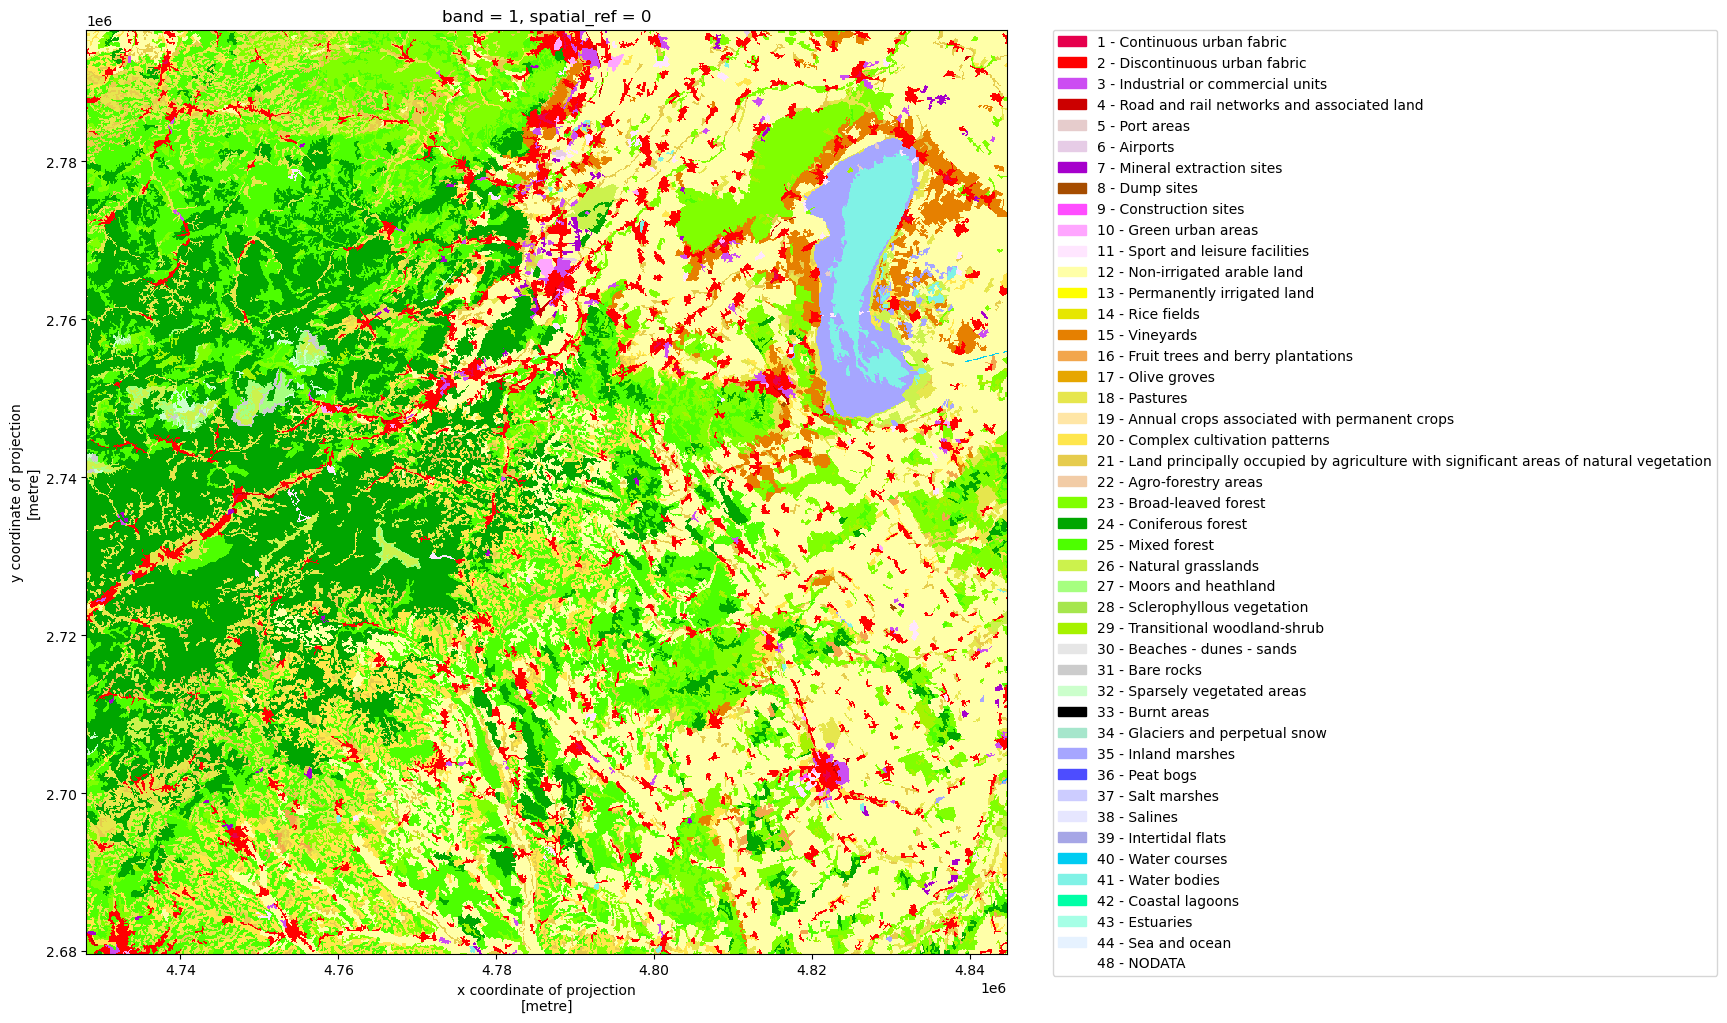

In [14]:
ax = ds_corine['band_data'].plot(figsize=(17, 12), cmap=cmap, norm=norm, add_colorbar=False)
ax.axes.set_aspect('equal')
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

## Alignment of the datasets

In [18]:
print("ds_corine details:")
print(ds_corine.rio.crs)
print(ds_corine.rio.bounds())
print(ds_corine.rio.resolution())

print("\nds_backscatter details:")
print(ds_backscatter.rio.crs)
print(ds_backscatter.rio.bounds())
print(ds_backscatter.rio.resolution())

ds_corine details:
PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]
(4728100.0, 2679700.0, 4844600.0, 2796700.0)
(100.0, -100.0)

ds_backscatter details:
EPSG:3035
(4728101.713910273, 2679704.353635614, 4844559.993472351, 2796700.5007221834)
(9.960509712801764, -9.960509712801764)


Both datasets have the same Coordinate Reverence System as we reprojected the Sentinel-1 data to the EPSG:3035. We can see that the bounds are shifted by 1 meter in x and 4 m. For the Corine Landcover data there is a geometric accuracy of ≤ 10 m so the shift seems to be fine.

Now which dataset should be projected on which one? Should the backscatter dataset be reprojected+downsampled

In [29]:
# this does koordinate converting + alignment so some steps before that are not necessary

# ds does not need to be converted we only need the box for loading the corine data. And maybee there is even soemthing to load corine like
#   load(corine).box_of(ds_backscatter) something like that

# !renameing!
ds_backscatter_match = ds.rio.reproject_match(ds_corine)


 ds_backscatter_match details:
PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]
(4728100.0, 2679700.0, 4844600.0, 2796700.0)
(100.0, -100.0)


In [30]:
print("ds_corine details:")
print(ds_corine.rio.crs)
print(ds_corine.rio.bounds())
print(ds_corine.rio.resolution())

print("\n ds_backscatter_match details:")
print(ds_backscatter_match.rio.crs)
print(ds_backscatter_match.rio.bounds())
print(ds_backscatter_match.rio.resolution())

ds_corine details:
PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]
(4728100.0, 2679700.0, 4844600.0, 2796700.0)
(100.0, -100.0)

 ds_backscatter_match details:
PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"

## Creating Masks

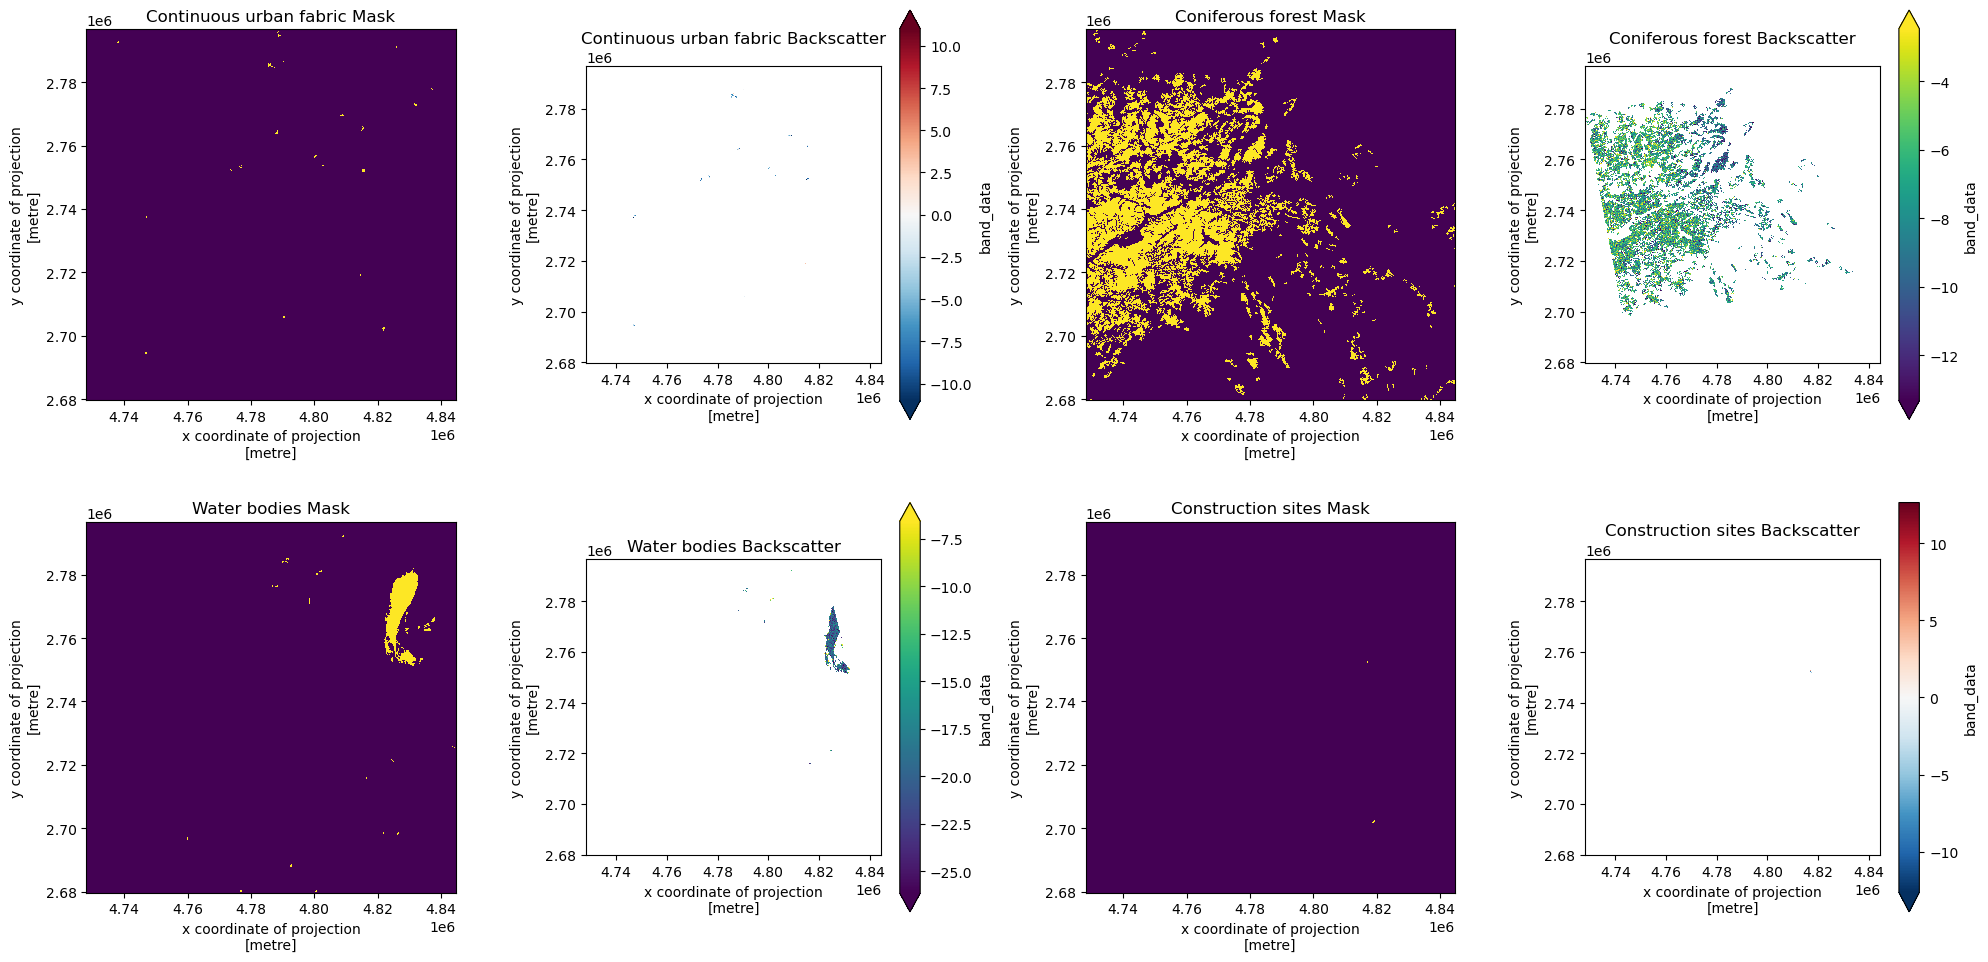

In [62]:
def plot_land_features_with_backscatter_and_histogramm(ds_corine, ds_backscatter, feature_codes):
    """
    Plot specified land features and their corresponding backscatter data.
    
    Parameters:
    ds_corine (xarray.Dataset): The CORINE dataset with land features.
    ds_backscatter (xarray.Dataset): The backscatter dataset.
    feature_codes (list of int): List of land feature codes to extract and plot.
    """

    # Create subplots
    n_features = len(feature_codes)
    n_cols = 4
    n_rows = (n_features * 2) // n_cols + ((n_features * 2) % n_cols > 0)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
    axes = axes.flatten()

    for idx, code in enumerate(feature_codes):
        if code not in color_mapping:
            print(f"Feature code {code} is not in the color mapping.")
            continue

        feature_color, feature_name = color_mapping[code]

        # Generate mask for the feature
        mask = (ds_corine == code)
        mask = mask.compute()

        # Extract the backscatter data for this feature
        feature_backscatter = ds_backscatter.where(mask)

        # Plot the mask
        mask['band_data'].plot(ax=axes[idx * 2], add_colorbar=False)
        axes[idx * 2].set_title(f"{feature_name} Mask")

        # Plot the corresponding backscatter
        feature_backscatter['band_data'].plot(ax=axes[idx * 2 + 1], robust=True)
        axes[idx * 2 + 1].set_title(f"{feature_name} Backscatter")

        # Set equal aspect ratio for both plots
        axes[idx * 2].set_aspect('equal')
        axes[idx * 2 + 1].set_aspect('equal')

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

# Example usage
feature_codes = [1, 24, 41, 9]  # List of land features (numbers) to plot
plot_land_features_with_backscatter_and_histogramm(ds_corine, ds_backscatter_match, feature_codes)


In [67]:
import matplotlib.pyplot as plt
import numpy as np

def plot_land_features_with_backscatter(ds_corine, ds_backscatter, feature_codes):
    """
    Plot specified land features, their corresponding backscatter data, and histograms of backscatter values.
    
    Parameters:
    ds_corine (xarray.Dataset): The CORINE dataset with land features.
    ds_backscatter (xarray.Dataset): The backscatter dataset.
    feature_codes (list of int): List of land feature codes to extract and plot.
    """
    
    # Create subplots
    n_features = len(feature_codes)
    n_cols = 3
    n_rows = n_features
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
    axes = axes.flatten()

    for idx, code in enumerate(feature_codes):
        if code not in color_mapping:
            print(f"Feature code {code} is not in the color mapping.")
            continue

        feature_color, feature_name = color_mapping[code]

        # Generate mask for the feature
        mask = (ds_corine == code)
        mask = mask.compute()

        # Extract the backscatter data for this feature
        feature_backscatter = ds_backscatter.where(mask)
        backscatter_values = feature_backscatter['band_data'].values.flatten()
        backscatter_values = backscatter_values[~np.isnan(backscatter_values)]

        # Plot the mask
        axes[idx * 3].imshow(mask['band_data'], vmin=0, vmax=1)
        axes[idx * 3].set_title(f"{feature_name} Mask")
        axes[idx * 3].axis('off')

        # Plot the masked backscatter
        feature_backscatter['band_data'].plot(ax=axes[idx * 3 + 1], robust=True)
        axes[idx * 3 + 1].set_title(f"{feature_name} Backscatter")

        # Plot the histogram of backscatter values
        axes[idx * 3 + 2].hist(backscatter_values, bins=30, color='blue', edgecolor='black')
        axes[idx * 3 + 2].set_title(f"{feature_name} Backscatter Histogram")
        axes[idx * 3 + 2].set_xlabel('Backscatter Value')
        axes[idx * 3 + 2].set_ylabel('Frequency')

        # Set equal aspect ratio for the mask and backscatter plots
        axes[idx * 3].set_aspect('equal')
        axes[idx * 3 + 1].set_aspect('equal')

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

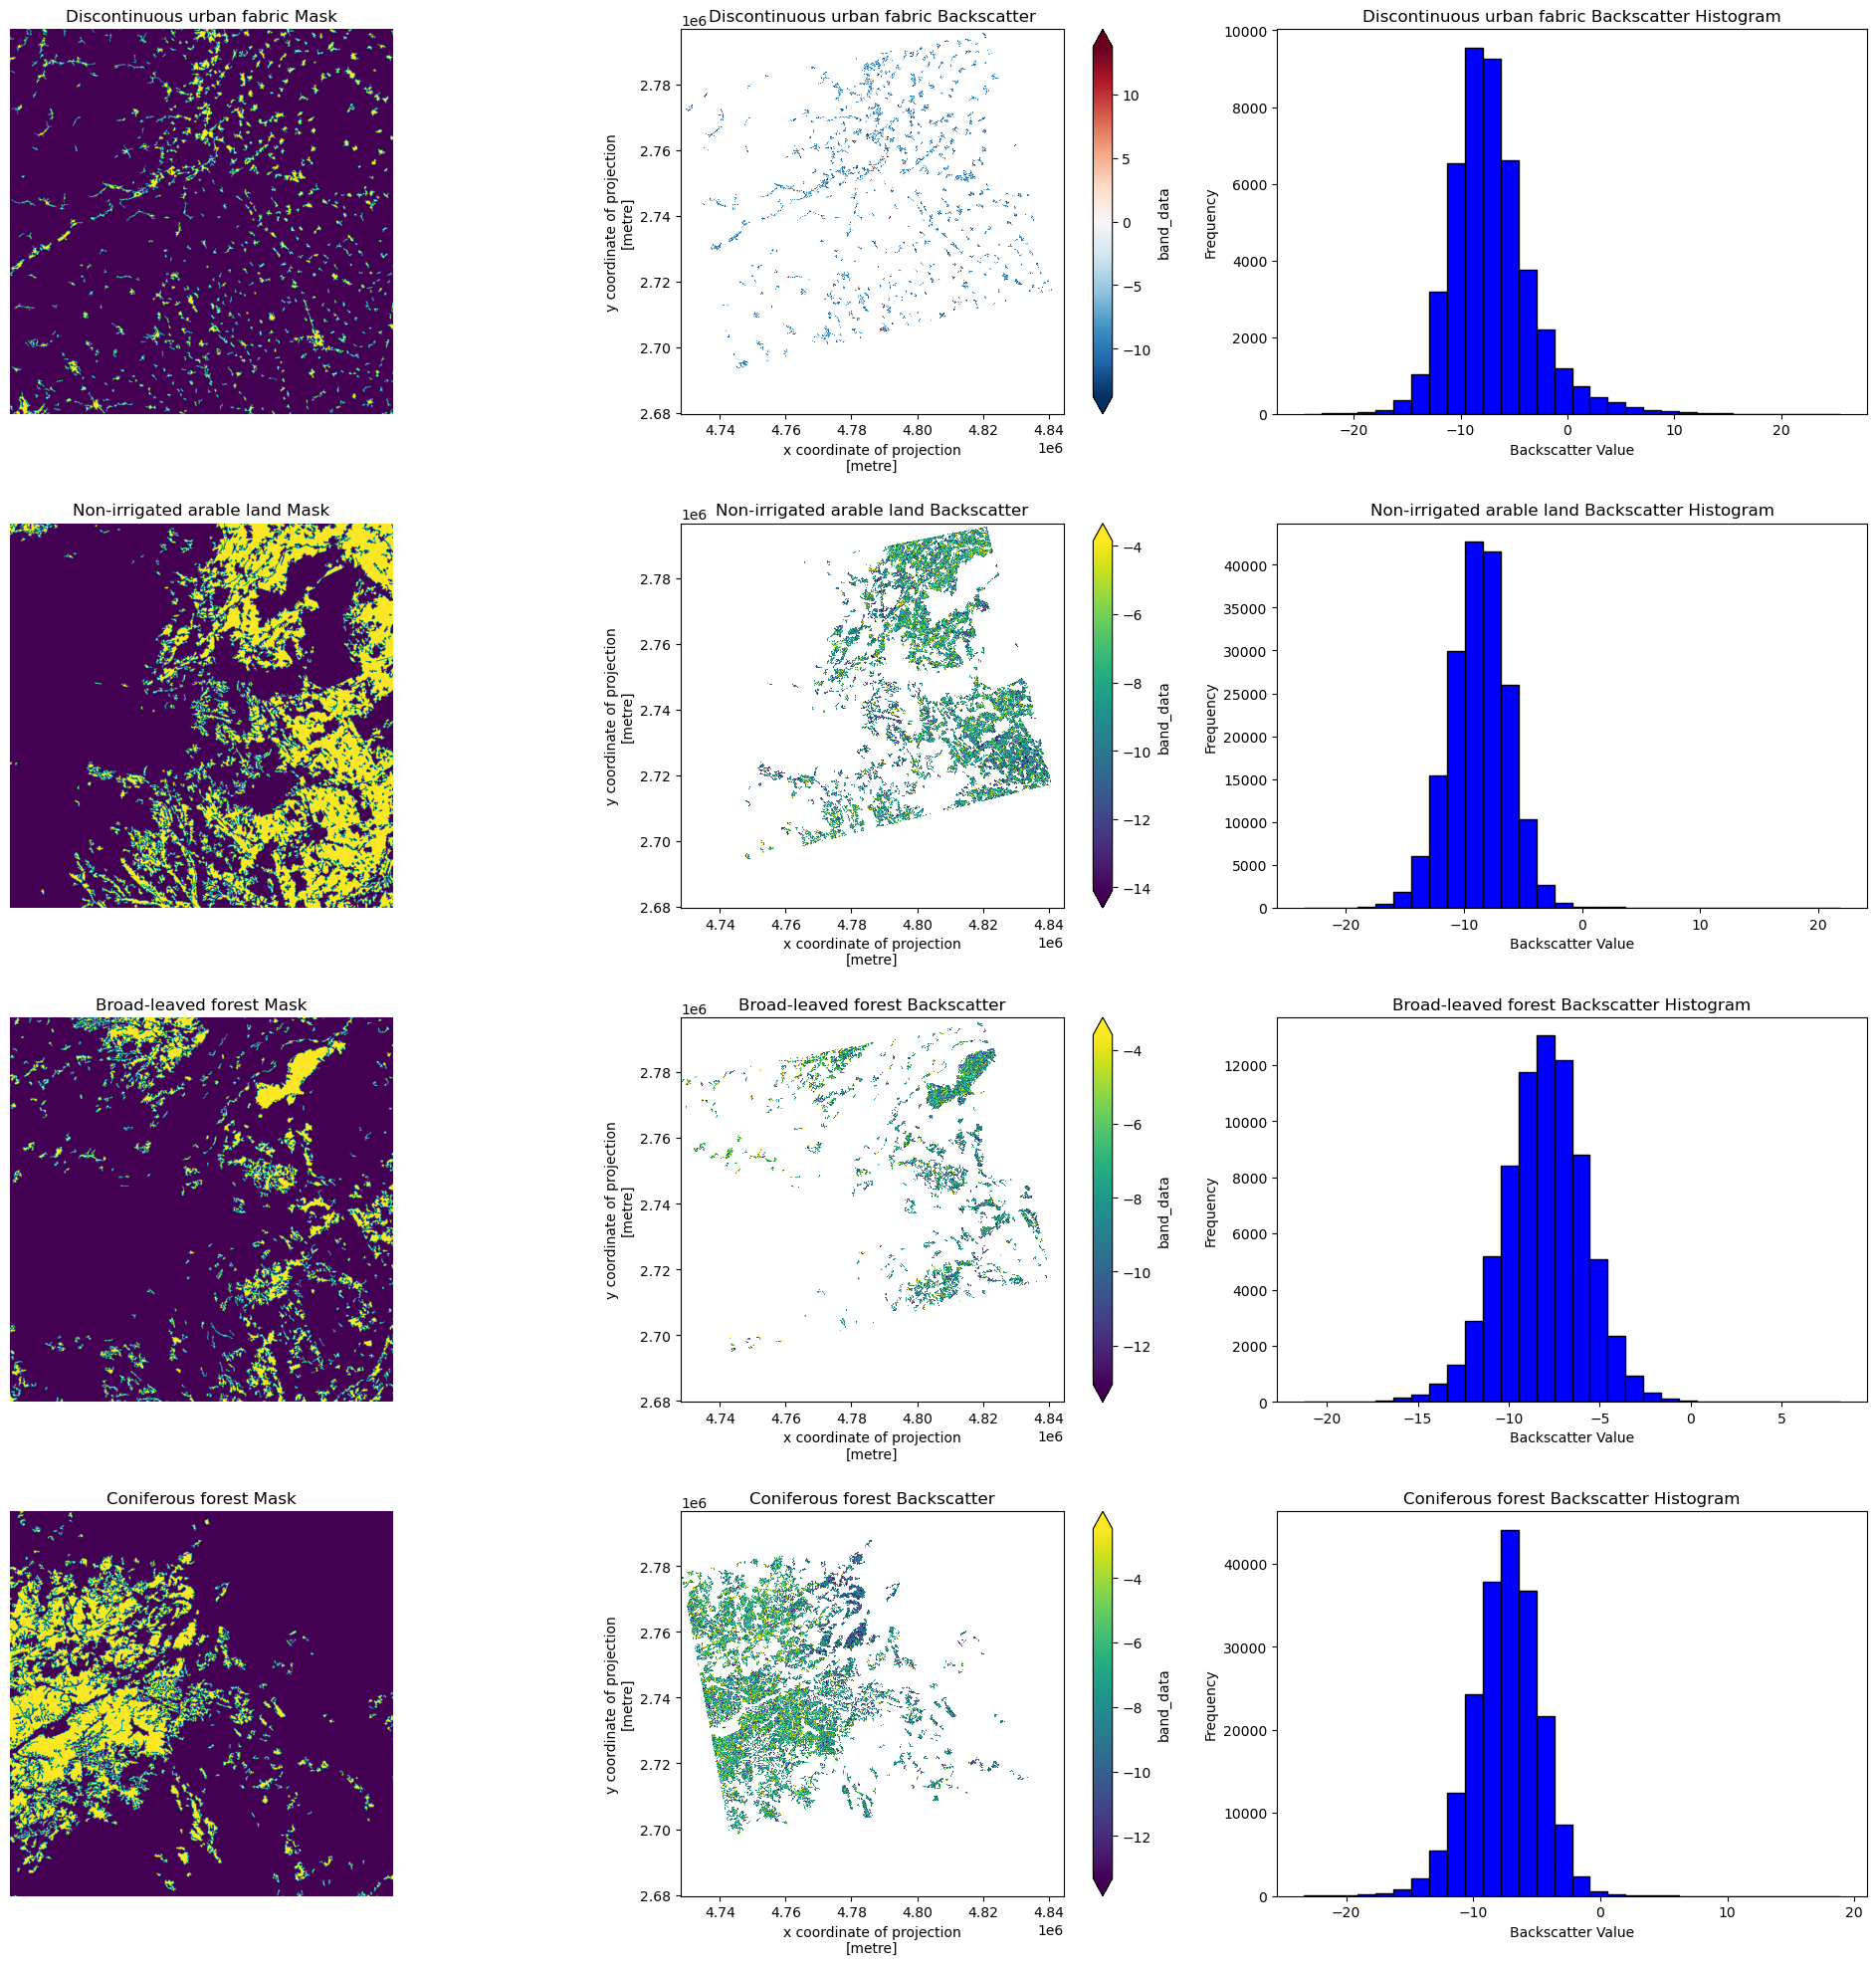

In [70]:
feature_codes = [2,12,23,24]
plot_land_features_with_backscatter(ds_corine, ds_backscatter_match, feature_codes)

## Histograms on different landtypes

# Code not curently used ------------------------------------------

In [58]:
continous_urban_fabric_mask = (ds_corine == 1)
coniferous_forest_mask = (ds_corine == 24)
inland_marshes_mask = (ds_corine == 37)
water_bodies_mask = (ds_corine == 41)

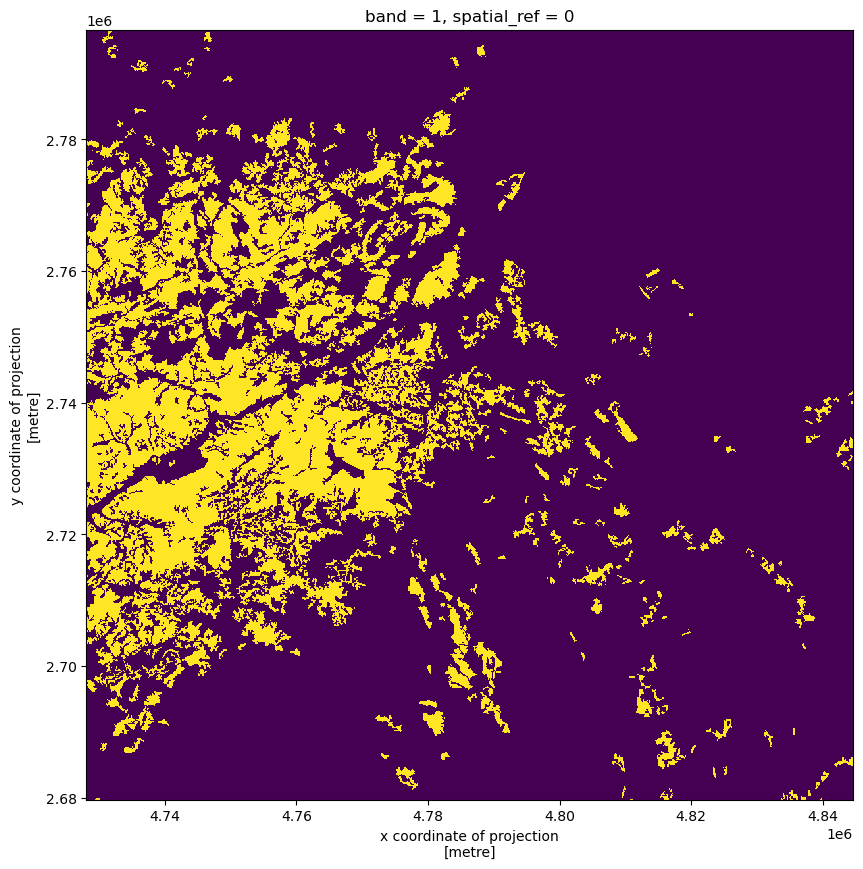

In [52]:
coniferious_forest_mask['band_data'].plot(add_colorbar=False, figsize=(15, 10)).axes.set_aspect('equal')

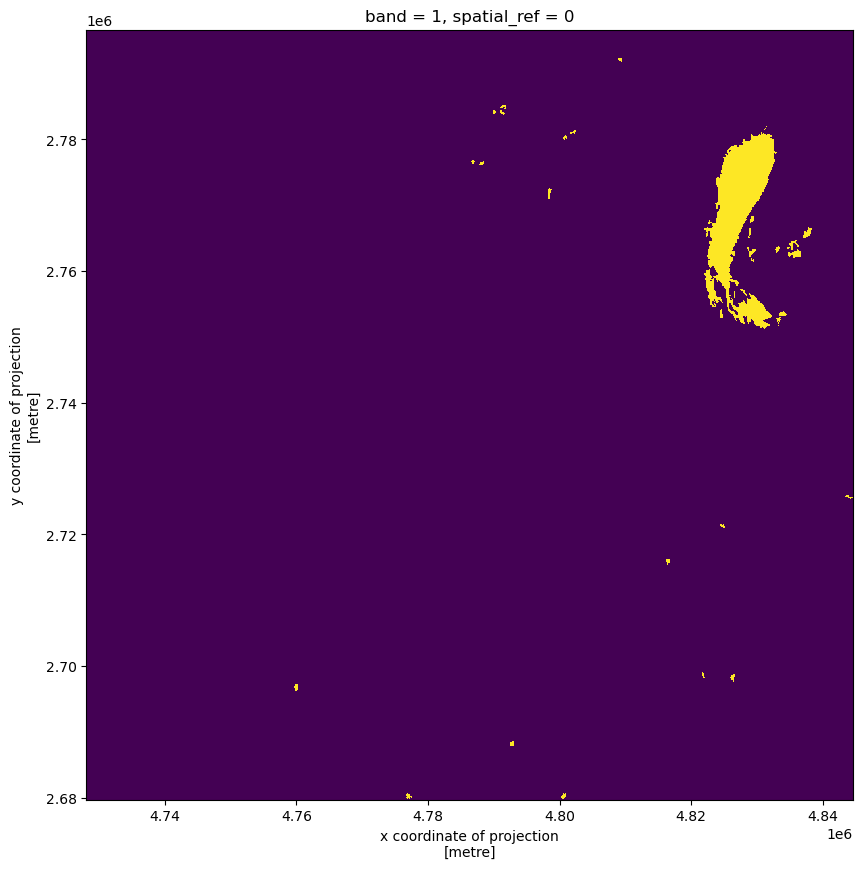

In [51]:
water_bodies_mask['band_data'].plot(add_colorbar=False, figsize=(15, 10)).axes.set_aspect('equal')

In [53]:
# apply mask to backscatter data

water_bodies_backscatter = ds_backscatter_match.where(water_bodies_mask)
coniferious_forest_backscatter = ds_backscatter_match.where(coniferious_forest_mask)

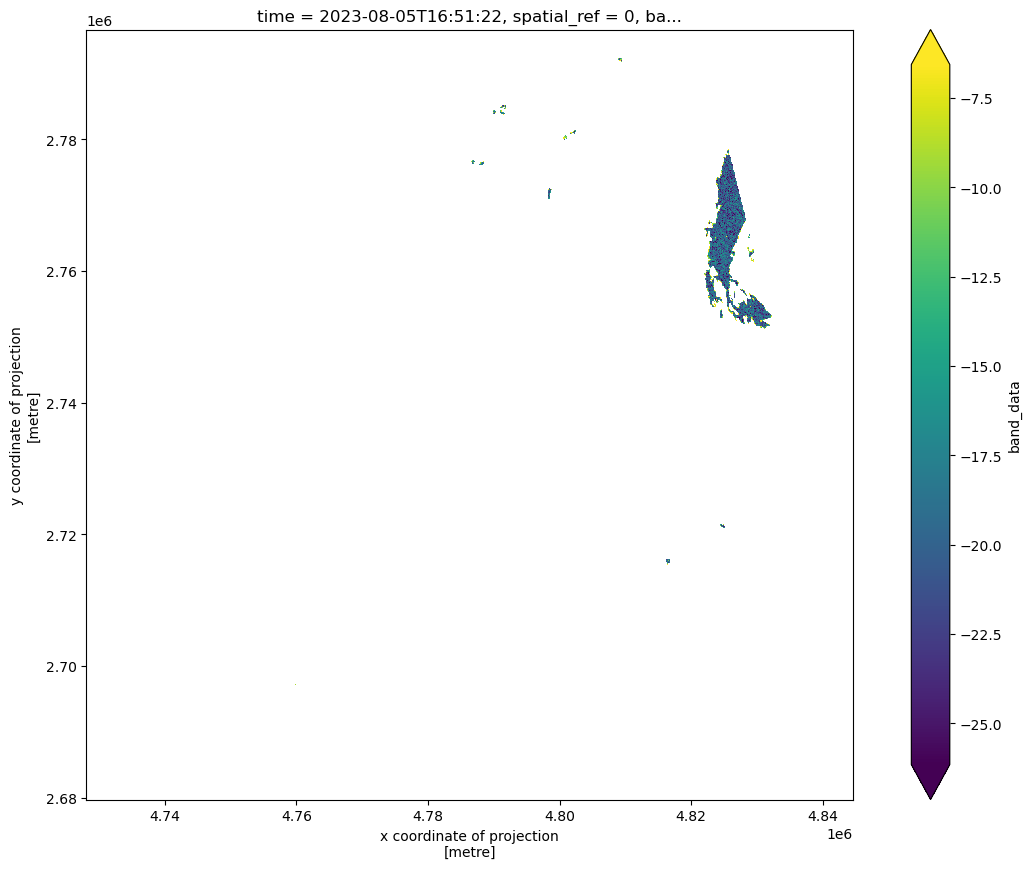

In [56]:
water_bodies_backscatter['band_data'].plot(figsize=(15, 10), robust=True).axes.set_aspect('equal')

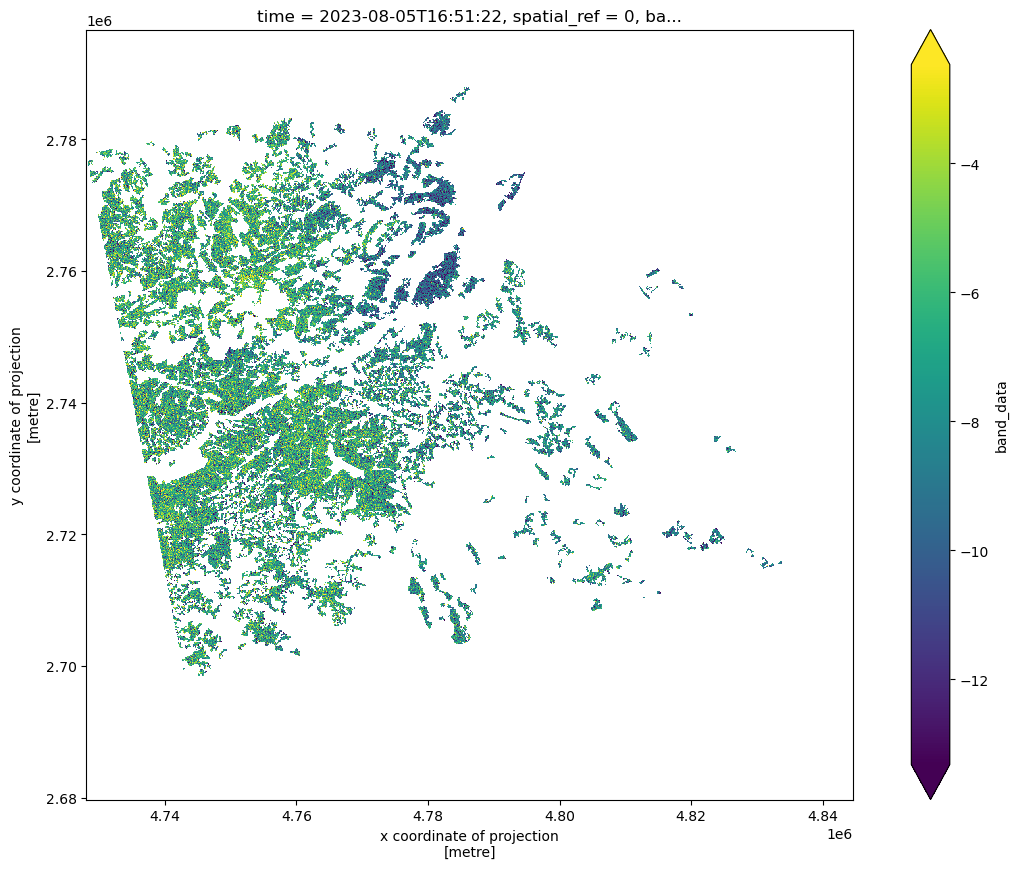

In [57]:
coniferious_forest_backscatter['band_data'].plot(figsize=(15, 10), robust=True).axes.set_aspect('equal')

In [ ]:
ds_corine_bounded['band_data'].plot(figsize=(15, 10), cmap=cmap, norm= norm).axes.set_aspect('equal')

### Convert the Box to 3035
The Sentinel data is in EPSG:27704. So we need to reproject the box to the coordinate system of the Corine Landcover data which has EPSG:3035.

In [ ]:
from shapely.geometry import box
from pyproj import Transformer

old_bbox_27704 = ds.rio.transform_bounds(ds.rio.crs)


transformer = Transformer.from_crs("EPSG:27704", "EPSG:3035", always_xy=True)

min_x_3035, min_y_3035 = transformer.transform(old_bbox_27704[0], old_bbox_27704[1])
max_x_3035, max_y_3035 = transformer.transform(old_bbox_27704[2], old_bbox_27704[3])

old_clip_bbox_3035 = box(min_x_3035, min_y_3035, max_x_3035, max_y_3035)

coords = list(clip_bbox_3035.exterior.coords)
coords

In [ ]:
ds_corine_bounded = ds_corine.rio.clip([clip_bbox_3035], crs=ds_corine.rio.crs, drop=True).squeeze()
ds_corine_bounded

In [ ]:
ds_corine_bounded['band_data'].plot(figsize=(15, 10))

In [ ]:
ds_corine_bounded['band_data'].plot(figsize=(15, 10), cmap="terrain").axes.set_aspect('equal')

In [ ]:
# load new data and only take the area we want

def clip_dataset_to_shape_file(ds, clip_shape_file="'~/shared/datasets/rs/datapool/mrs/Corine_Land_Cover_2018.tif'"):
    bbox = ds.rio.transform_bounds("EPSG:4326")
    clip_shape = gpd.read_file(clip_shape_file).cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    ds = ds.rio.clip(clip_shape.geometry.apply(mapping), clip_shape.crs, invert=False)
    return ds

In [ ]:
xslice = ds_corine['band_data'].coords['x']
yslice = ds_corine['band_data'].coords['y']

len(yslice)

In [ ]:
test = ds_corine['band_data'].isel(x=slice(52_000, 52_100), y=slice(15_000, 15_100))#.squeeze()
test

In [ ]:
test.plot()

### Plot all in low resolution

In [ ]:
ds_corine_downscaled = ds_corine.coarsen(x=1000, y=1000, boundary='pad').mean()
ds_corine_downscaled = ds_corine_downscaled.chunk({"x": 100, "y": 100})
ds_corine_downscaled

### Transform the areas to the different coordinate system

In [ ]:
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:27704", "EPSG:3035", always_xy=True)

In [ ]:
area_corine_dataarrays = {}

for area in converted_areas:
    roi = ds_corine.sel(
        x=slice(area['x_min'], area['x_max']),
        y=slice(area['y_max'], area['y_min'])
    )    
    area_corine_dataarrays[area['name']] = roi

ds_corine_area1 = area_corine_dataarrays['area1']
ds_corine_area2 = area_corine_dataarrays['area2']

ds_corine_area2.plot.scatter()

## Plotting in the EPSG:27704
In the EPSG:27704 coordinate system (plotting is quite slow):

## Get the overlapping area

In [ ]:
data_vars = list(ds_WGS84.data_vars)

ds_overlapping = ds_WGS84[data_vars[0]]  # Start with the first variable

for var in data_vars[1:]:
    next_image = ds_WGS84[var]
    ds_overlapping = ds_overlapping.rio.clip_box(*next_image.rio.bounds())

To reduce the runtime we downsample the data to make the plotting faster.

In [ ]:
ds_downsampled = ds_WGS84.isel().coarsen(x=10, y=10, boundary='pad').mean()
ds_overlapping_downsampled = ds_overlapping.isel().coarsen(x=10, y=10, boundary='pad').mean()

In [ ]:
ds_downsampled[data_vars[0]].plot()

In [ ]:
ds_overlapping_downsampled.plot()

We transform our Data to the EPSG:4326 coordinate system which uses Latitude and Longitude values.

In [ ]:
ds_WGS84 = ds.rio.reproject("EPSG:4326")
ds_WGS84